In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf

In [2]:
date_block_mapping = {
    0: dt.datetime(2013, 1, 1), 1: dt.datetime(2013, 2, 1), 2: dt.datetime(2013, 3, 1), 3: dt.datetime(2013, 4, 1),
    4: dt.datetime(2013, 5, 1), 5: dt.datetime(2013, 6, 1), 6: dt.datetime(2013, 7, 1), 7: dt.datetime(2013, 8, 1),
    8: dt.datetime(2013, 9, 1), 9: dt.datetime(2013, 10, 1), 10: dt.datetime(2013, 11, 1), 11: dt.datetime(2013, 12, 1),
    12: dt.datetime(2014, 1, 1), 13: dt.datetime(2014, 2, 1), 14: dt.datetime(2014, 3, 1), 15: dt.datetime(2014, 4, 1),
    16: dt.datetime(2014, 5, 1), 17: dt.datetime(2014, 6, 1), 18: dt.datetime(2014, 7, 1), 19: dt.datetime(2014, 8, 1),
    20: dt.datetime(2014, 9, 1), 21: dt.datetime(2014, 10, 1), 22: dt.datetime(2014, 11, 1), 23: dt.datetime(2014, 12, 1),
    24: dt.datetime(2015, 1, 1), 25: dt.datetime(2015, 2, 1), 26: dt.datetime(2015, 3, 1), 27: dt.datetime(2015, 4, 1),
    28: dt.datetime(2015, 5, 1), 29: dt.datetime(2015, 6, 1), 30: dt.datetime(2015, 7, 1), 31: dt.datetime(2015, 8, 1),
    32: dt.datetime(2015, 9, 1), 33: dt.datetime(2015, 10, 1)
}

# Plan

### - For the first iteration of this project I am focusing on predicting 
### future sales for 1 product/item (grouping all shops together)


### - In the second iteration I can extend this to make predictions for 
### individual shops/group shops based on patterns etc
### - Predictions will be made on weekly data for practicality 
### (difficult to control stock on a daily basis but monthly less granular)
### - Planning to write script/program to make prediction for each item



# 1. Exploratory data analysis and visualization:

###       - Pick product with most sales 



###    - understand general demand for item

        Is there typical purchasing behaviours/a measurable pattern?
        Is there an autocorrelation above 0.5 at any point? Focus on where there is a linear pattern?
        Is there cross-correlation across years? Cycle?
        Can I find non-linear patterns?


###    - understand general demand for shops (second iteration)
        Do certain shops have more typical purchasing behaviours? Is there a measurable pattern?
        Is there a way to group shops by trend? eg are some shops visited more during christmas 
        and others are visited more during the weekends
        How much do shops vary around mean (standard deviation, coefficient of variation)?
        Is there a cross-correlation between any shops?
        which shops are customers more likely to go to during high demand seasons or days
        What shops perform above and below the average (outliers)?
        How to remove outliers or split shops up by popularity/number of sales? z score or interquartile range?


# 2. Model fitting and predictions


###     - Data cleaning/prep

        What moving average parameters am I using?

        What groups have I created?

        Am I adding additional features eg season?
                Month/Season/Event 
                Number of sales in the previous year?
                Number of sales/average in the previous week, two weeks or month?
                popularity of shop/group?
                Number of popular items in shop?
                Average price that week
                Price change (actual value)

        Outliers removed?

        Data imputation - where there is a measurable pattern I will add in values for missing data


###    Starting with simple model then complex - most likely not enough data for deep learning/AI

        - Regression: ARIMA/autoregression
        
                Independent Variables:
                        Month/Season/Event 
                        Number of sales in the previous year?
                        Number of sales/average in the previous week, two weeks or month?
                        popularity of shop/group?
                        Number of popular items in shop?

                Dependent Variable:
                        Number of sales next day/week


        - Bayesian 


        - Machine Learning
            Can K-means clustering be used to determine whether there is a pattern and what the variables are?
            SVM & XGBOOST

    
    


## Conclusions/findings 


       Average number of sales decreasing yearly (less data collected?)
       Price of same item is different across shops and dates (different promotions?)
       
       - What timeframe was the dataset collected?
        2 years 10 months - Jan 2013 - Oct 2015

        Data is negatively skewed - more shops have sales within the lower end from 0 to ~3000

        Items have different prices across shops and dates

       new possible features:

       Average price that week

       Price change (actual value)




        



# 1. Exploratory data analysis and visualization:

###       - Pick product with most sales and understand general characteristics eg what is the general trend?

    


In [29]:
sales = pd.read_csv('data/sales_train.csv')
sales = sales[(sales['item_cnt_day'] > 0 ) & (sales['item_price'] > 0)] # only rows that have a price and item count
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True)
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15
5,2013-01-10,0,25,2564,349.00,1.0,2013,1,10


    - What timeframe was the dataset collected?

Jan 2013 - Oct 2015

In [171]:
print(sales['date'].max(),sales['date'].min())

2015-10-31 00:00:00 2013-01-01 00:00:00


### Items have different prices across shops and dates

new possible features:

Average price that week

Price change (actual value)

In [ ]:
# same date and item, different prices
sales[(sales['item_id'] == 32) & (sales['date'] == '2013-01-03')].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
40085,2013-01-03,0,0,32,221.0,2.0,2013,1,3
31260,2013-01-03,0,6,32,349.0,1.0,2013,1,3
58567,2013-01-03,0,13,32,221.0,1.0,2013,1,3
45904,2013-01-03,0,16,32,349.0,1.0,2013,1,3
10000,2013-01-03,0,19,32,349.0,1.0,2013,1,3


In [56]:
weekly_sales_dict = {}
years = sales['date'].dt.year.unique()

for y in years:
    
    yearly_data = sales[sales['date'].dt.year == y]
    
    # calculates average weekly sales for each item
    
    weekly_sales_per_shop = yearly_data.groupby([pd.Grouper(key='date', freq='W'), 'item_id', 'shop_id'])['item_cnt_day'].sum().reset_index()
    
    weekly_sales_total = weekly_sales_per_shop.groupby([pd.Grouper(key='date', freq='W'), 'item_id'])['item_cnt_day'].sum().reset_index(name='total_sales')
    
    shop_counts = weekly_sales_per_shop.groupby([pd.Grouper(key='date', freq='W'), 'item_id'])['shop_id'].nunique().reset_index(name='shop_count')
    
    merged = pd.merge(weekly_sales_total, shop_counts, on=['date', 'item_id'])
    
    merged['average_weekly_sales'] = merged['total_sales'] / merged['shop_count']
    
    # Adjust week numbers for year transition
    merged['week'] = merged['date'].dt.strftime('%U').astype(int)
    merged.loc[merged['date'].dt.year == y + 1, 'week'] = 53
    
    # Add the result to the dictionary
    weekly_sales_dict[y] = merged

In [84]:
all_sales = pd.concat(weekly_sales_dict.values(), ignore_index=True)
all_sales['year'] = all_sales['date'].dt.year

fig = px.line(all_sales[all_sales['average_weekly_sales'] > 9], x='week', y='average_weekly_sales', color='item_id',
              title='Items Purchased per Week', facet_col='year')
fig.update_layout(xaxis_title='Week', yaxis_title='Items Sold')
fig.show()

## Will focus on item 20949 - most sales/data to test on

In [85]:
fig = px.line(all_sales[all_sales['item_id'] == 20949], x='week', y='average_weekly_sales', color='year',title='Items Purchased per Week')
fig.update_layout(xaxis_title='Date', yaxis_title='Items Sold')
fig.show()

## Moving average applied to df's to reduce noise & aid visualization

In [86]:
# 4 for 1 month
def apply_moving_average(df, window=4):
    df['moving_avg'] = df.groupby('item_id')['average_weekly_sales'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    return df

for year in weekly_sales_dict:
    weekly_sales_dict[year] = apply_moving_average(weekly_sales_dict[year])

all_sales = pd.concat(weekly_sales_dict.values(), ignore_index=True)
all_sales['year'] = all_sales['date'].dt.year

# Filter for the specific item_id
item_id = 20949
filtered_sales = all_sales[all_sales['item_id'] == item_id]

In [87]:
# Plot with moving average lines for each year
fig = px.line(
    filtered_sales,
    x='week',
    y='moving_avg',
    color='year',  # Use 'year' to differentiate lines by year
    title=f'Moving Average of Items Purchased per Week for Item {item_id}',
    labels={'year': 'Year', 'moving_avg': 'Moving Average'},
)

fig.update_layout(xaxis_title='Week', yaxis_title='Moving Average of Items Sold')
fig.show()


## Possible pattern observed in 2013 and 2014

## lack of similarity in 2015 could be due to lack of data

next steps:

plot standard deviation for item 20949 between shops - how much variability is there? how to group shops?

test on dataset from week 22 = 06-02

In [149]:
data_dict = {key: df[(df['item_id'] == item_id)] for key, df in weekly_sales_dict.items()}
data_dict[2014]

,date,item_id,total_sales,shop_count,average_weekly_sales,week,moving_avg
4258,2014-01-05,20949,1924.0,43,44.744186,1,44.744186
9145,2014-01-12,20949,1825.0,44,41.477273,2,43.110729
13563,2014-01-19,20949,1348.0,43,31.348837,3,39.190099
17945,2014-01-26,20949,1397.0,43,32.488372,4,37.514667
22285,2014-02-02,20949,1489.0,43,34.627907,5,34.985597
26581,2014-02-09,20949,1536.0,43,35.720930,6,33.546512
31060,2014-02-16,20949,1575.0,42,37.500000,7,35.084302
35713,2014-02-23,20949,1953.0,43,45.418605,8,38.316860
39991,2014-03-02,20949,1459.0,44,33.159091,9,37.949656
44490,2014-03-09,20949,1772.0,45,39.377778,10,38.863868


# Autocorrelation results - daily average (not used)

Autocorelation calculated on data before sliding average applied

Expected seasonality for retail data

Less data collected in 2015 explains difference in correlation, likely not enough data 
to reveal pattern though pattern is still slightly comparable to 2013.

There is a moderate positive autocorrelation at lag of 7, which peaks in 7 day intervals, though this decreases in significance over time

Suggests that if sales on one day were higher than average, sales will be increased at a similar rate 7 days later and vice versa

This may also be true for 14 and 21 days later, but with a weaker similarity in distance from average

There may also be a moderate positive correlation at lag of 1 meaning if sales increased yesterday they may similarly increase the next day.

### Two new features:

Difference from average sales 7 days prior (standard deviation)

Actual number of sales 7 days prior

Could also incorporate difference the day before, 14 and 21 days to see how this affects accuracy



# Autocorrelation results - weekly average

## Within years
There is a moderate positive correlation at lag 1 

Previously mentioned pattern between sales from one week to the next

### Two new features:

Difference from average sales the week before (standard deviation)

Actual number of sales the week before

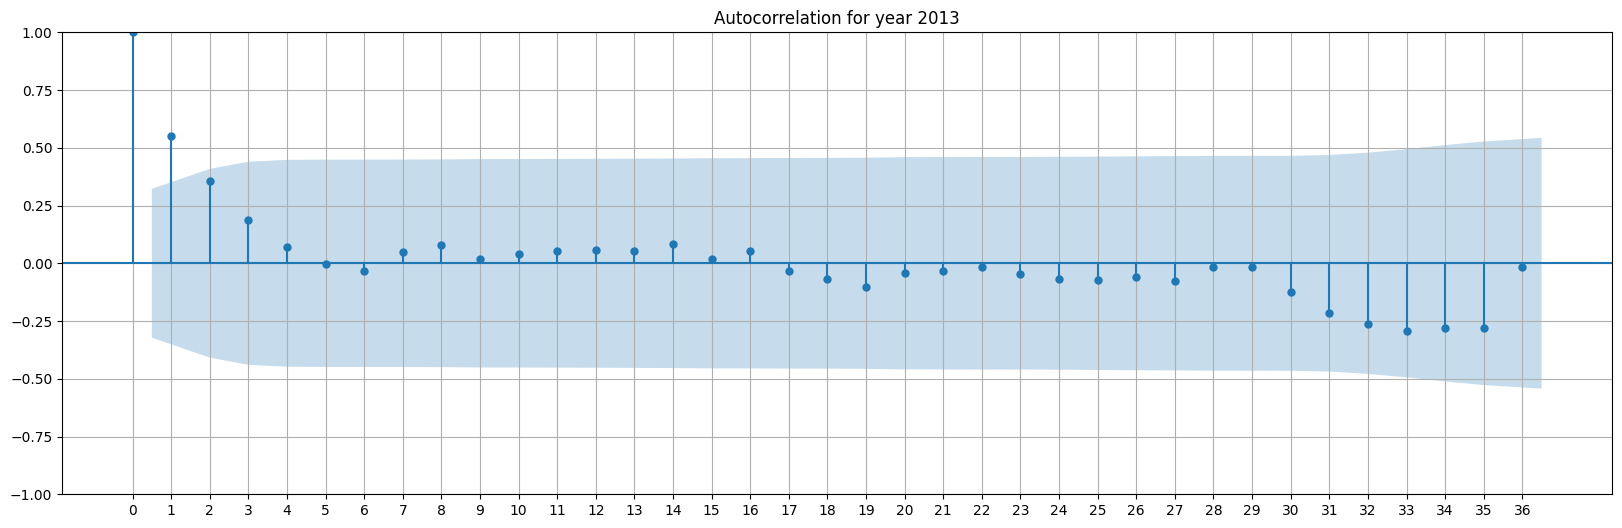

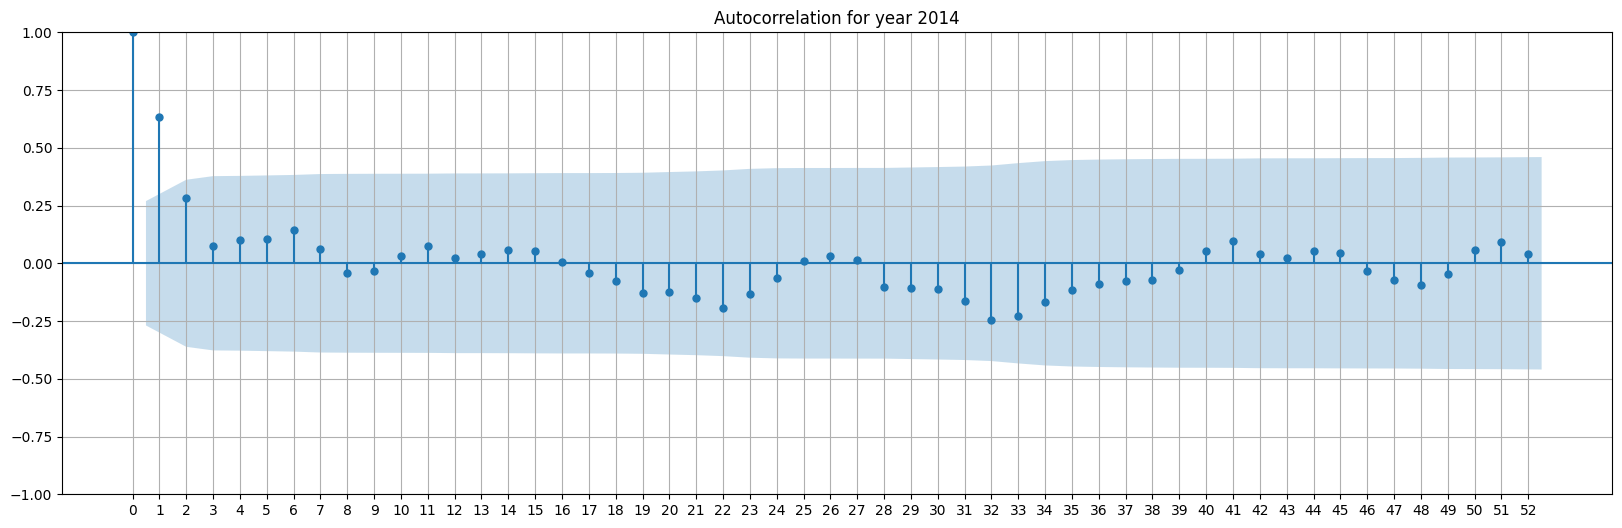

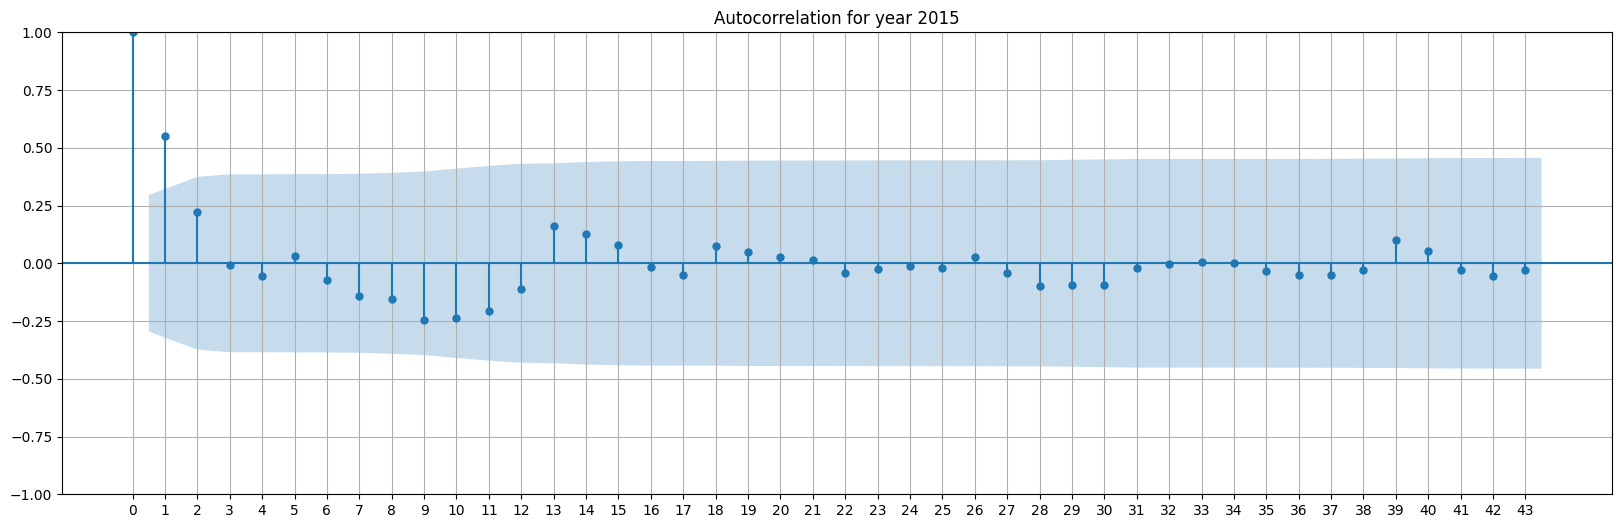

In [152]:

def plot_autocorrelation(year, data):
    
    # Plot autocorrelation
    fig, ax = plt.subplots(figsize=(20, 6))  # Adjust figsize as needed
    plot_acf(data['total_sales'], ax=ax, title=f'Autocorrelation for year {year}', lags=len(data)-1)
    
    # Customize x-axis ticks
    ax.set_xticks(range(0, len(data), 1))  # Set ticks every 1 unit
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))  # Format x-axis labels as integers
    
    # Add grid lines
    ax.grid(True)
    
    plt.show()



# Plot autocorrelation for each year
for year in years:
    plot_autocorrelation(year, data_dict[year])  

In [128]:
all_sales = all_sales[all_sales['item_id'] == 20949]
all_sales

,date,item_id,total_sales,shop_count,average_weekly_sales,week,moving_avg,year
90712,2013-04-28,20949,152.0,15,10.133333,17,10.133333,2013
96059,2013-05-05,20949,602.0,25,24.080000,18,17.106667,2013
101045,2013-05-12,20949,625.0,30,20.833333,19,18.348889,2013
105967,2013-05-19,20949,790.0,34,23.235294,20,19.570490,2013
111105,2013-05-26,20949,1003.0,36,27.861111,21,24.002435,2013
...,...,...,...,...,...,...,...,...
621749,2015-10-04,20949,765.0,38,20.131579,40,20.868827,2015
624870,2015-10-11,20949,839.0,37,22.675676,41,21.037746,2015
627895,2015-10-18,20949,1362.0,38,35.842105,42,24.822596,2015
631008,2015-10-25,20949,793.0,37,21.432432,43,25.020448,2015


In [158]:
print(len(data_dict[2013]),len(data_dict[2014]),len(data_dict[2015]))

37 53 44


# Cross-correlation between years 

Double check if there is pattern across years/where the strongest correlations are

as seen in visualization datasets for 2013 and 2014 are very similar - could be used for training/testing

standardised datasets

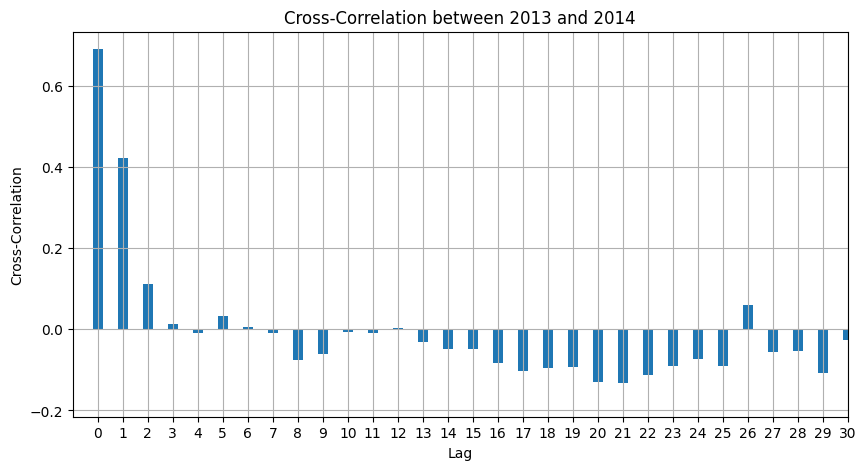

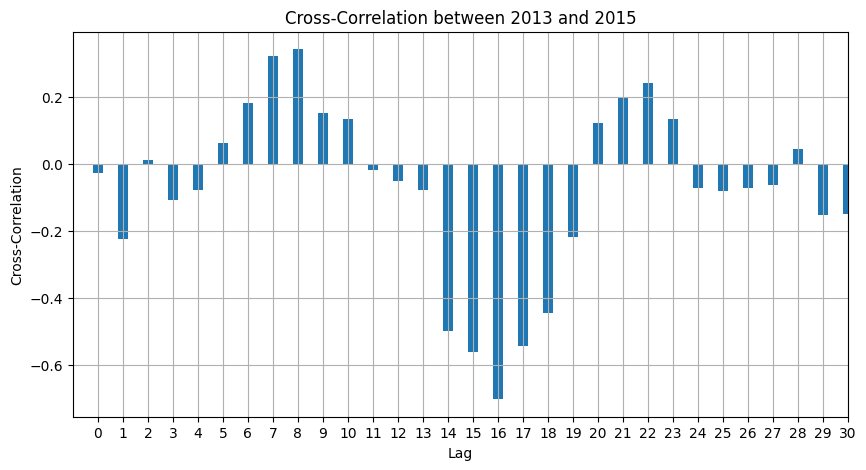

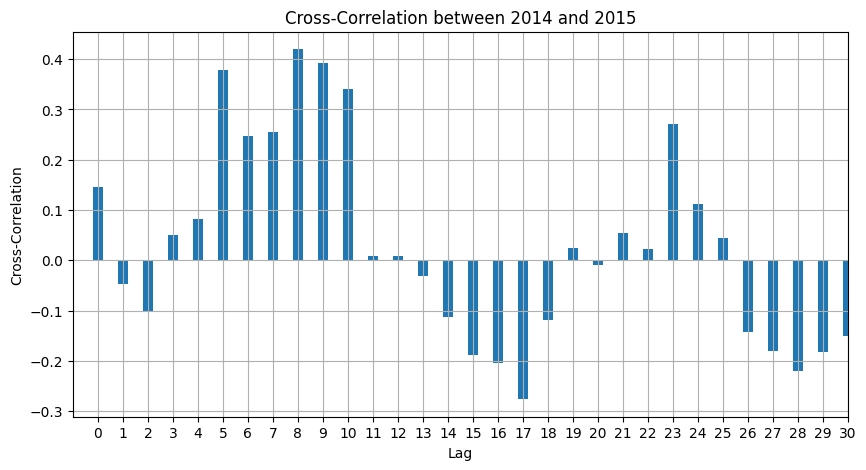

In [170]:

def plot_cross_correlation(ts1, ts2, title):
    correlation = ccf(ts1['average_weekly_sales'], ts2['average_weekly_sales'], adjusted=False)
    lags = np.arange(len(correlation))
    
    plt.figure(figsize=(10, 5))
    plt.bar(lags, correlation, width=0.4)
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.grid(True)  # Add grid lines
    plt.xticks(lags)  # Set xticks to show all numbers
    plt.xlim(-1, 30)  # Limit x-axis to range from 0 to 30
    plt.show()

# Plot cross-correlation for each pair of years
plot_cross_correlation(data_dict[2013], data_dict[2014][data_dict[2014]['week'] >= 17], 'Cross-Correlation between 2013 and 2014')
plot_cross_correlation(data_dict[2013][data_dict[2013]['week'] <= 44], data_dict[2015], 'Cross-Correlation between 2013 and 2015')
plot_cross_correlation(data_dict[2014][data_dict[2014]['week'] <= 44], data_dict[2015], 'Cross-Correlation between 2014 and 2015')